In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima, ADFTest
from sklearn.metrics import r2_score,mean_squared_error 

plt.rcParams["figure.figsize"] = (16,9)

In [2]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
ticker = "PNC"
df = yf.download(ticker, start="2020-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [4]:
adf_test = ADFTest(alpha = 0.05) # CL: 95%
adf_test.should_diff(df['Close'])


(0.7414371196614109, True)

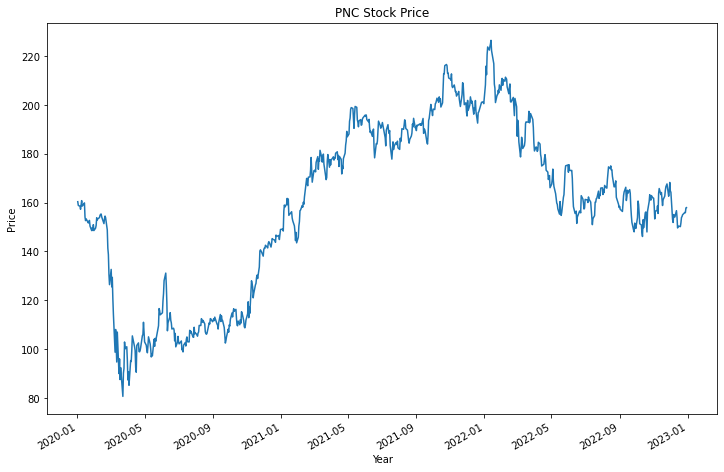

In [5]:
df['Close'].plot(figsize=(12, 8))
plt.xlabel("Year")
plt.ylabel("Price")
plt.title(f"{ticker} Stock Price")
plt.show()

In [6]:
# split train test
train_data = df[:int(df.shape[0] * 0.8)]
test_data = df[int(df.shape[0] * 0.8):]

y_actual = test_data['Close']
model = auto_arima(train_data['Close'], start_p = 0, d=1,start_q=0,max_p = 5,
                    max_d = 5, max_q = 5, start_P = 0, D = 1, start_Q=0,
                      max_P = 5, max_D = 5, max_Q = 5, m = 12, seasonal=True, error_action='warn',
                      trace=True, suppress_warnings=True, stepwise=True, 
                      random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3573.178, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3416.064, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3574.496, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3345.547, Time=0.97 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3301.000, Time=1.55 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=3290.311, Time=2.35 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=3242.371, Time=12.59 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=3202.197, Time=27.48 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=10.01 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=3203.276, Time=23.56 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=12.02 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=3205.355, Time=7.55 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=3203.895, Time=10.12 sec
 ARIMA(1,1,1)(5,1,1)[12]    

In [7]:
# model summary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  604
Model:             SARIMAX(1, 1, 0)x(5, 1, [1], 12)   Log Likelihood               -1593.098
Date:                              Mon, 27 Feb 2023   AIC                           3202.197
Time:                                      21:22:45   BIC                           3237.251
Sample:                                           0   HQIC                          3215.852
                                              - 604                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0951      0.033     -2.863      0.004      -0.160      -0.030
ar.S.L12      -0.1542      0.059     -2.635      0.008      -0.269      -0.040
ar.S.L24      -0.1624      0.055     -2.954      0.003      -0.270      -0.055
ar.S.L36      -0.1356      0.055     -2.451      0.014      -0.244      -0.027
ar.S.L48      -0.0986      0.053     -1.851      0.064      -0.203       0.006
ar.S.L60      -0.1849      0.051     -3.651      0.000      -0.284      -0.086
ma.S.L12      -0.8178      0.046    -17.714      0.000      -0.908      -0.727
sigma2        12.3197      0.603     20.445      0.000      11.139      13.501
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                28.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# model.fit(test_data['Close'])
# forcasting
future_forecast = model.predict(n_periods=len(test_data), alpha=0.5)
future_forecast

c:\Users\SARAN\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


604    164.492510
605    164.536917
606    163.833233
607    165.386539
608    165.474372
          ...    
751    120.854892
752    120.151614
753    120.233354
754    120.701670
755    119.339743
Length: 152, dtype: float64

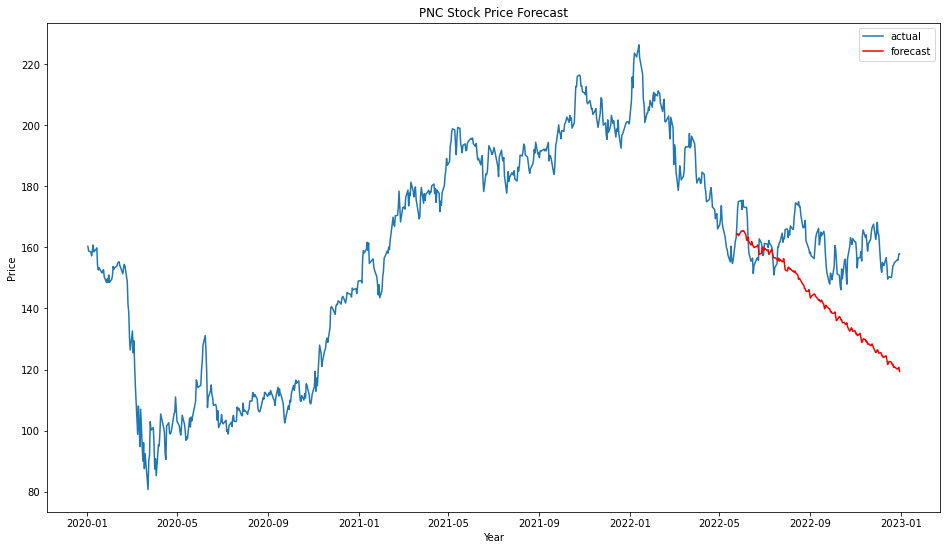

Test MSE : 460.5043228194403
Test R-score:  -8.856456283971458


In [9]:
plt.plot(df['Close'],label = 'actual')
plt.plot(y_actual.index,future_forecast, color='red',label = "forecast")
plt.xlabel("Year")
plt.ylabel("Price")
plt.title(f"{ticker} Stock Price Forecast")
plt.legend()
plt.show()
mse = mean_squared_error(y_actual,future_forecast.values)
r_score = r2_score(y_actual,future_forecast)
print("Test MSE :",mse)
print("Test R-score: ", r_score)

In [10]:
df['Close'][-30:]

Date
2022-11-17    158.800003
2022-11-18    161.160004
2022-11-21    162.660004
2022-11-22    164.979996
2022-11-23    166.500000
2022-11-25    167.649994
2022-11-28    162.610001
2022-11-29    164.369995
2022-11-30    168.259995
2022-12-01    164.800003
2022-12-02    164.229996
2022-12-05    153.110001
2022-12-06    151.860001
2022-12-07    155.100006
2022-12-08    154.339996
2022-12-09    154.080002
2022-12-12    156.699997
2022-12-13    154.029999
2022-12-14    149.619995
2022-12-15    150.179993
2022-12-16    150.389999
2022-12-19    150.160004
2022-12-20    151.679993
2022-12-21    153.899994
2022-12-22    154.289993
2022-12-23    155.020004
2022-12-27    155.960007
2022-12-28    155.860001
2022-12-29    157.830002
2022-12-30    157.940002
Name: Close, dtype: float64

In [11]:
future_forecast

604    164.492510
605    164.536917
606    163.833233
607    165.386539
608    165.474372
          ...    
751    120.854892
752    120.151614
753    120.233354
754    120.701670
755    119.339743
Length: 152, dtype: float64